In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF
from src.utils.trainer import ModelTrainer

from src.models.vaegan import VAEGAN_Gen, VAEGAN_Disc, Initializer

import numpy as np
import os

%load_ext autoreload
%autoreload 2

In [3]:
TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'vaegan-imagenet')
IMAGE_SZ = (64, 64)
NUM_WORKERS = 4
GIF_DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature'
IMG_DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/TinyImageNet'
IMG_BATCH_SZ = 128
GIF_BATCH_SZ = 64
TRANSFORMS = transforms.Compose([transforms.Resize(IMAGE_SZ), transforms.ToTensor()])
DISP_LIM = 8

In [4]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

def lstm_flatten(x):
    B, T = x.shape[0], x.shape[1]
    return x.view(B, T, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [5]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

def lstm_flatten(x):
    B, T = x.shape[0], x.shape[1]
    return x.view(B, T, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [6]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [7]:
MAX_FRAMES = 10

gif_train_set = TGIF(
    root=f'{GIF_DATASET_ROOT}/train',
    preload=False,
    max_frames=MAX_FRAMES,
    transform=TRANSFORMS
)

gif_val_set = TGIF(
    root=f'{GIF_DATASET_ROOT}/val',
    preload=False,
    max_frames=MAX_FRAMES,
    transform=TRANSFORMS,
)

gif_test_set = TGIF(
    root=f'{GIF_DATASET_ROOT}/test',
    preload=False,
    max_frames=MAX_FRAMES,
    transform=TRANSFORMS
)

print(len(gif_train_set), len(gif_val_set), len(gif_test_set))

3995 750 250


In [8]:
gif_train_loader = DataLoader(gif_train_set, batch_size=GIF_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
gif_val_loader = DataLoader(gif_val_set, batch_size=GIF_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
gif_test_loader = DataLoader(gif_val_set, batch_size=GIF_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

In [9]:
img_train_set = dset.ImageFolder(f'{IMG_DATASET_ROOT}/train', transform=TRANSFORMS)
img_val_set = dset.ImageFolder(f'{IMG_DATASET_ROOT}/test', transform=TRANSFORMS)
img_test_set = dset.ImageFolder(f'{IMG_DATASET_ROOT}/val', transform=TRANSFORMS)

print(len(img_train_set), len(img_val_set), len(img_test_set))

100000 10000 10000


In [10]:
img_train_loader = DataLoader(img_train_set, batch_size=IMG_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
img_val_loader = DataLoader(img_val_set, batch_size=IMG_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
img_test_loader = DataLoader(img_val_set, batch_size=IMG_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def gif_show(gif):
    npimg = gif.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(20,40))
    plt.imshow(out)

torch.Size([40, 3, 64, 64])


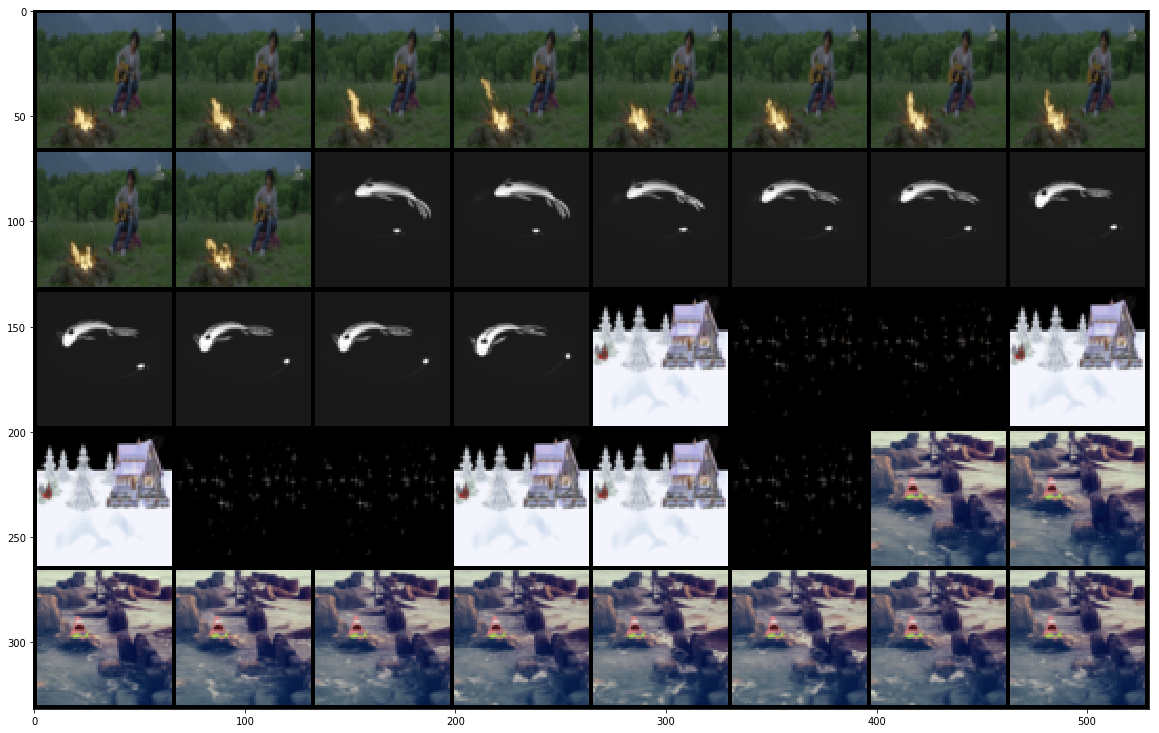

In [12]:
%matplotlib inline
gifs = []
for i, gif in enumerate(gif_train_loader):
    gifs.append(gif[0])
    if i == 3:
        break
        
gif = torch.cat(tuple(gifs), dim=0)
print (gif.shape)
gif_show(torchvision.utils.make_grid(gif))

torch.Size([128, 3, 64, 64])


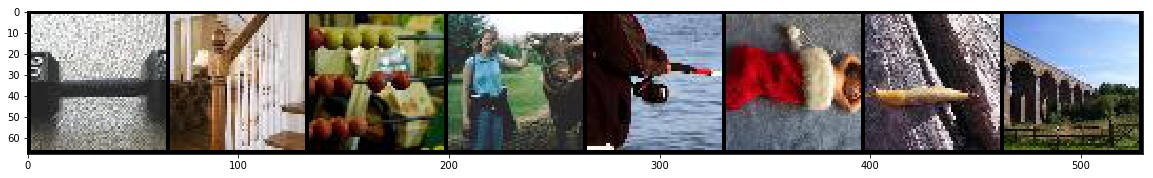

In [13]:
%matplotlib inline
img = iter(img_train_loader).next()[0]
print (img.shape)
gif_show(torchvision.utils.make_grid(img[:DISP_LIM]))

## Different Loss Functions

In [14]:
def train_fn(model, optimizer, inp, d_optimizer):
    def loss_fn(recon_x, x, mu, logvar):
        mse_loss = nn.MSELoss(size_average=False)
        MSE = mse_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD
        
    model.train()
    x = inp[0]
    x = x.to(device=device, dtype=dtype)
    recon_x, mu, logvar = model(x)

    loss = loss_fn(recon_x, x, mu, logvar)
    loss.cuda().backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

def train_fn_l1(model, optimizer, inp, use_gdl=True, d_optimizer=None):
    def loss_fn(recon_x, x, mu, logvar):
        p = 1
        l1_loss = nn.L1Loss(size_average=False)
        
        L1 = l1_loss(recon_x, x)

        GDL = 0
        
        if use_gdl:
            GDL_1 = torch.abs(torch.abs(recon_x[:, :, :, :-1] - recon_x[:, :, :, 1:]) - torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) ** p
            GDL_2 = torch.abs(torch.abs(recon_x[:, :, :-1, :] - recon_x[:, :, 1:, :]) - torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])) ** p

            GDL =  (torch.sum(GDL_1) + torch.sum(GDL_2))/x.shape[0]
              
            
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return L1 + GDL + KLD
        
    model.train()
    x = inp[0]
    x = x.to(device=device, dtype=dtype)
    recon_x, mu, logvar = model(x)

    loss = loss_fn(recon_x, x, mu, logvar)
    loss.cuda().backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()


In [235]:

def train_gan(gen_model, disc_model,  g_optimizer, d_optimizer, loader, epochs=4, print_every=100, save_every=100, verbose=True):
    
    criterion = nn.BCEWithLogitsLoss(size_average=True)
    
    gan_reg = 1e-5
    kl_reg = 1e-12
    
    disc_err_fake_reg = 1
    
    for e in range(epochs):
        for t, inp in enumerate(loader):

            gen_model.train()
            disc_model.train()            
            
            d_optimizer.zero_grad()
            
            x = inp[0]
            x = x.to(device=device, dtype=dtype)
                        
            recon_x, mu, logvar = gen_model(x)
            

            rec_noise = gen_model.decoder(torch.randn(x.shape[0], 95, device=device))  # TODO: magic numbers
            
            logits_real = disc_model(x).squeeze()
            logits_fake = disc_model(recon_x).squeeze()
            logits_err = disc_model(rec_noise).squeeze()
            


            all_ones = torch.ones(logits_real.shape[0], device=device)
            all_zeros = torch.zeros(logits_real.shape[0], device=device)
                
            # train discriminator
            disc_err_real = criterion(logits_real, all_ones)
            disc_err_fake = disc_err_fake_reg * criterion(logits_fake, all_zeros)
            disc_err_noise = criterion(logits_err, all_zeros)     # random noise
            
            disc_loss = disc_err_real + disc_err_fake


            disc_loss.backward()
            d_optimizer.step()

#             disc_loss = 0
            
            
            
            g_optimizer.zero_grad()
            recon_x, mu, logvar = gen_model(x)
            
            gen_logits_fake = disc_model(recon_x)
            gen_logits_fake = gen_logits_fake.squeeze()

            gen_loss_gan = gan_reg * criterion(gen_logits_fake, all_ones)

#             gen_loss_gan = 0 
            


            mse_loss = nn.MSELoss(size_average=True)
            MSE = mse_loss(recon_x, x)            
            
            KLD = kl_reg * (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
            
#             print(MSE.item(), KLD.item(), GAN_LAMBDA*gen_loss_gan.item())
            gen_loss = MSE + KLD + gen_loss_gan
            
            
            gen_loss.backward()
            g_optimizer.step()

            if verbose and t % print_every == 0:
                print(f'Epoch [{e}] ({t}/{len(loader)}), \t gen_loss  = {gen_loss:.4f} \t(recr: {MSE:.6f}, gan: {gen_loss_gan:.6f}, gan/recr: {gen_loss_gan/MSE:.4e}), \n\t\t\t ' 
                      +  f'disc_loss = {disc_loss:.4f} \t(real: {disc_err_real:.6f}, fake: {disc_err_fake:.6f})\n')



            if t % save_every == 0:
                pass
#                 self.save_data()
        if verbose:
            print (f'Epoch [{e}] done')


In [221]:
def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    return torch.stack(ret).transpose(0, 1)
    
def img_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[0]
    print (x.shape)
    x = torch.tensor(x)
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    gif_show(torchvision.utils.make_grid(imgs))
    
def gif_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[:, 0, :, :, :]
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    gif_show(torchvision.utils.make_grid(imgs))
    

In [222]:
NUM_CHANNELS = 3
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS

LATENT_SIZE = 95

gen = VAEGAN_Gen(latent_size=LATENT_SIZE, device=device)
disc = VAEGAN_Disc(latent_size=LATENT_SIZE, device=device)

Initializer.initialize(model=gen, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
Initializer.initialize(model=disc, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))

g_optimizer = optim.Adam(gen.parameters(), lr=1e-3)
d_optimizer = optim.Adam(disc.parameters(), lr=1e-3)


In [223]:
# g_optimizer = optim.Adam(gen.parameters(), lr=1e-4)
# d_optimizer = optim.Adam(disc.parameters(), lr=1e-3)

# disc = VAEGAN_Disc(latent_size=LATENT_SIZE, device=device)

In [234]:
try:
    print('Starting training...')
    train_gan(gen, disc, g_optimizer, d_optimizer, img_train_loader, epochs=2, print_every=100)

except KeyboardInterrupt:
    print("Force saving")
#     trainer.save_data(force_save=True)

Starting training...
Epoch [0] (0/781), 	 gen_loss  = 0.0234 	(recr: 0.023282, gan: 0.000078, gan/recr: 0.0033391027), 
			 disc_loss = 0.0010 	(real: 0.000399, fake: 0.000563)

Epoch [0] (100/781), 	 gen_loss  = 0.0228 	(recr: 0.022745, gan: 0.000076, gan/recr: 0.0033575422), 
			 disc_loss = 0.0014 	(real: 0.000692, fake: 0.000709)

Epoch [0] (200/781), 	 gen_loss  = 0.0219 	(recr: 0.021864, gan: 0.000080, gan/recr: 0.0036662419), 
			 disc_loss = 0.0008 	(real: 0.000387, fake: 0.000412)

Epoch [0] (300/781), 	 gen_loss  = 0.0213 	(recr: 0.021228, gan: 0.000081, gan/recr: 0.0038276566), 
			 disc_loss = 0.0007 	(real: 0.000341, fake: 0.000353)

Epoch [0] (400/781), 	 gen_loss  = 0.0208 	(recr: 0.020698, gan: 0.000082, gan/recr: 0.0039554462), 
			 disc_loss = 0.0008 	(real: 0.000455, fake: 0.000357)

Epoch [0] (500/781), 	 gen_loss  = 0.0223 	(recr: 0.022244, gan: 0.000077, gan/recr: 0.0034519592), 
			 disc_loss = 0.0014 	(real: 0.000699, fake: 0.000684)

Epoch [0] (600/781), 	 gen_

torch.Size([128, 3, 64, 64])


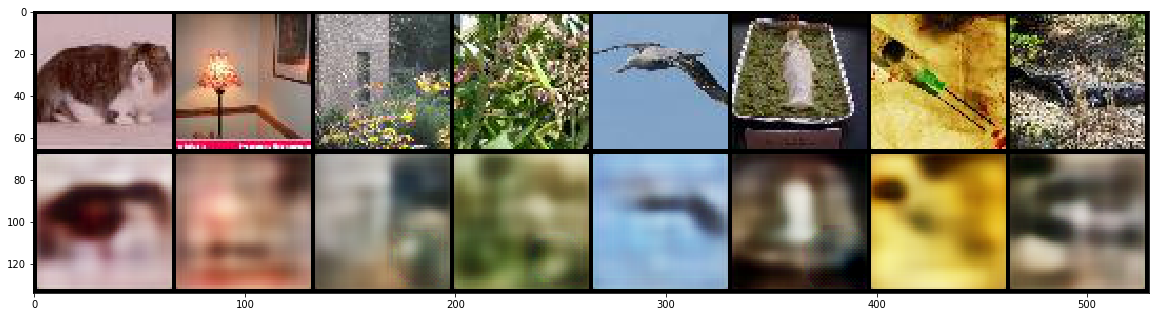

In [237]:
img_test_autoenc(gen, img_train_loader)

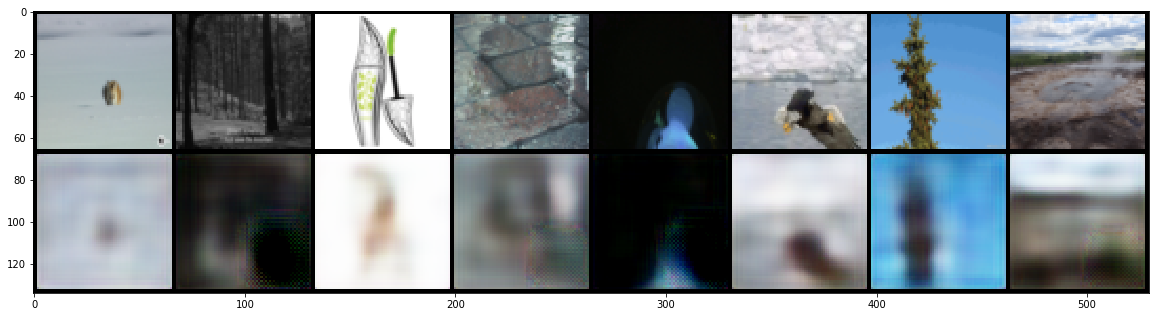

In [230]:
gif_test_autoenc(gen, gif_val_loader)

In [231]:
# gan_state = {
#     'gen_state_dict': gen.state_dict(),
#     'disc_state_dict': disc.state_dict(),
# #     'optimizer': self.optimizer.state_dict()
#     'config': 'gan_reg = 1e-4,kl_reg = 1e-14, disc_err_fake_reg = 1'

    
# }

# torch.save(gan_state, '/home/deepdeepfakes/cs231n-project/src/backups/vaegan-imagenet/vaegan-best')


## Varying Latent Space

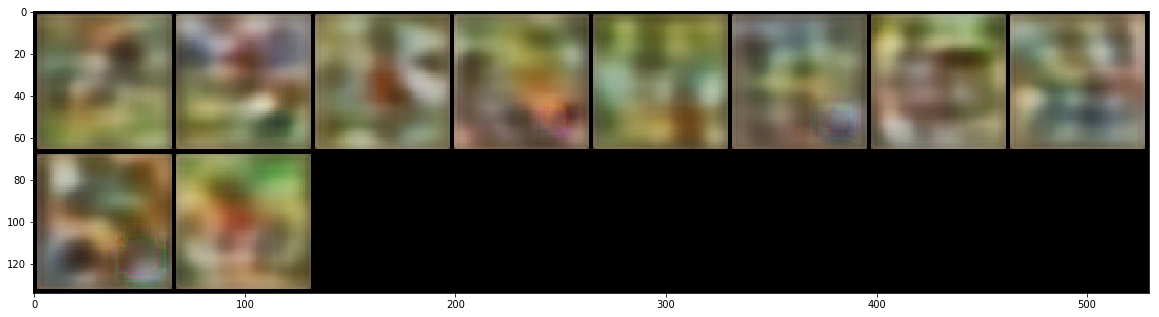

In [232]:

def gen_image(model):
    z = torch.randn((10, 95), device=device)
    y = model.decoder(z)
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    gif_show(torchvision.utils.make_grid(y))
    

gen_image(gen)

torch.Size([64, 95])


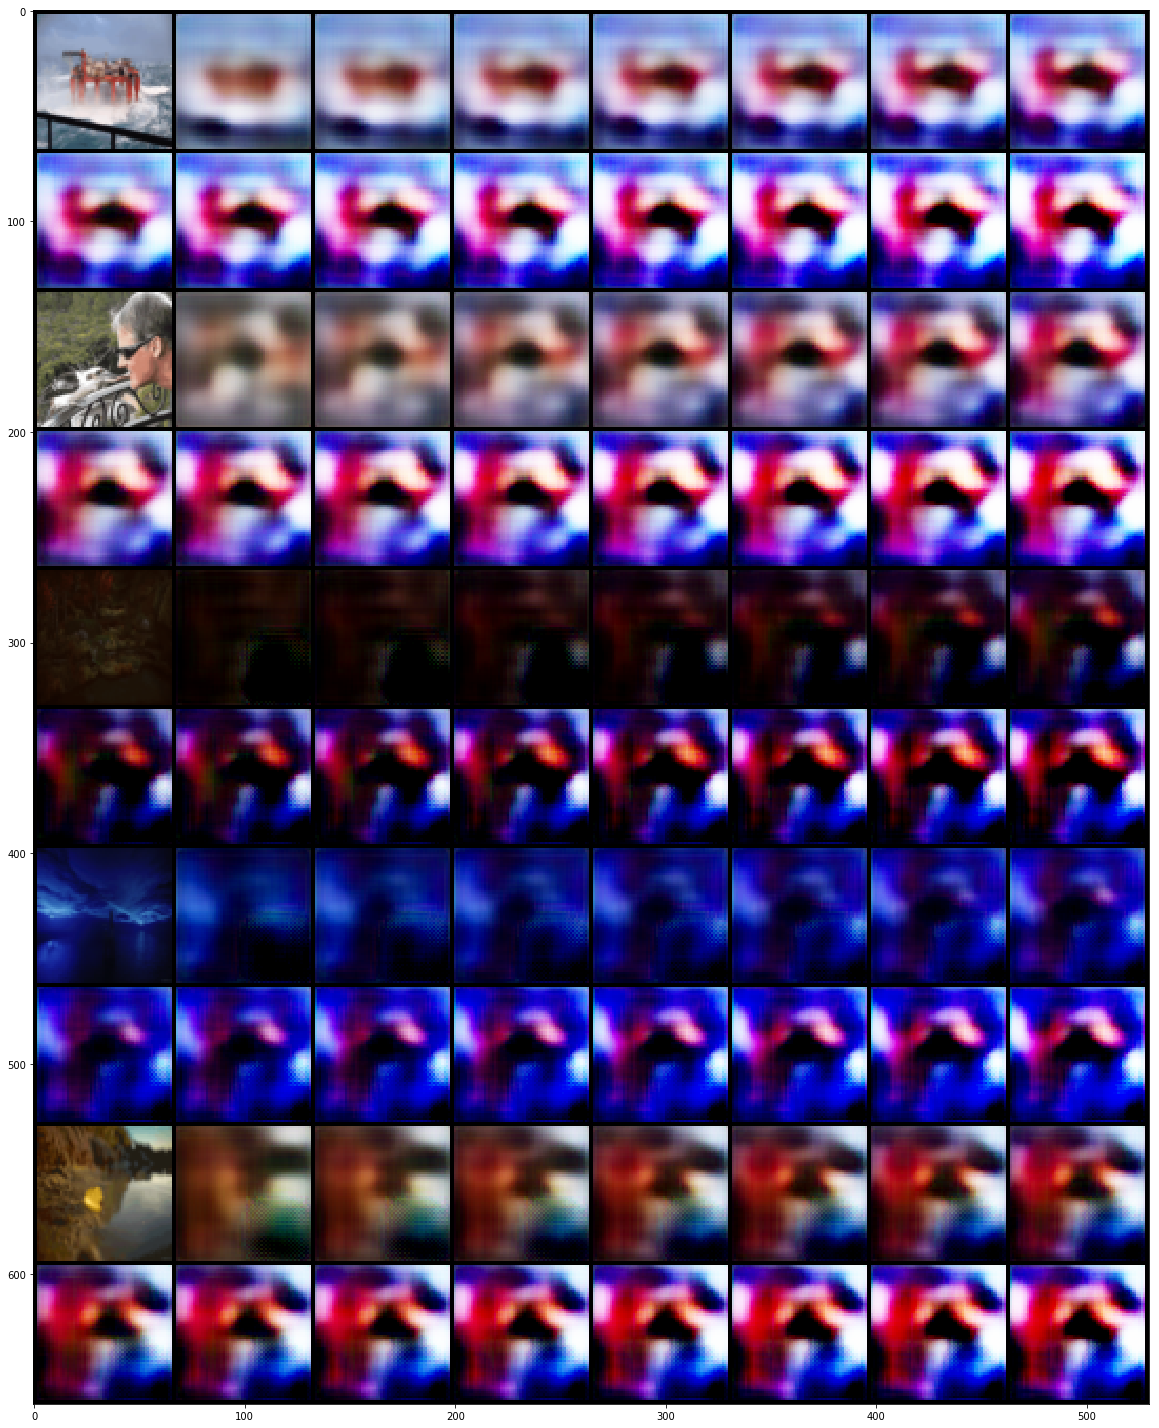

In [233]:
def vary_latent(init_z, step, length, dim, model, orig_img):
    print(init_z.shape)
    BATCH_IDX = 15
    BATCH_LIM = 5
    orig_img = orig_img.to(torch.device('cpu')).detach()

    ret = []
    curr_z = init_z.clone()
    curr_z = curr_z.to(device=device)
    
#     curr_z[dim] -= step*(length // 2)
    
    model.eval()
    for batch in range(BATCH_LIM):
        curr_z = init_z.clone()
        ret.append(orig_img[batch]) 
        for i in range(length):
            curr_z[:, dim] += step
            y = model.decoder(curr_z)
            y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
            ret.append(y[batch])
    
    gif_show(torchvision.utils.make_grid(torch.stack(ret)))
        
        
    

def get_latent_z(model, x):
    enc_y = model.encoder(x)
    mu, logvar = model.fc_mu(enc_y), model.fc_logvar(enc_y)
    return model.sample_latent(mu, logvar)


def sample_forward(model, z):
    return model.decoder(z)


def test_varying(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()    
#     x = x[0]
    x = x[:, 0, :, :, :]
    x = x.to(device=device, dtype=dtype)

    z = get_latent_z(model, x)
    vary_latent(z, 4.0, 15, 10, model, x)
    
test_varying(gen, gif_val_loader)